In [1]:
###### import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import os

from background_models import bg_dampe, dphi_de_egb_fermi
from constants import dampe_excess_bin_high, dampe_bins, fermi_psf
from constants import rho_earth, Hz_to_GeV2_cm3
from finite_clump_vectorized import rho_s_dampe, luminosity, dphi_de_g
from finite_clump_vectorized import gamma_ray_extent, line_width_constraint
from finite_clump_vectorized import fermi_point_src_contraint

from nfw_clump import NFW_params
from tt_clump import TT_params

colors = [c["color"] for c in plt.rcParams['axes.prop_cycle']]
# Photon energy at which to compute fluxes
e_gamma_ref = 230.
# Flux above which Fermi should absorb the clump as an extended source
dphi_de_g_fermi_ext = 1e-7  # (GeV cm^2 s sr)^2
# Significance used for line width constraint
n_sigma = 3.
# Directory with Ben's probability data files
pr_base_path = "../DAMPE+DM clumps/data/likelihoods/"

# NFW profile

In [3]:
gamma_nfw = 0.5
# gamma_nfw = 1.

dist = np.logspace(-3, 0, 10)
r_s = np.logspace(-3, 1, 10)
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

base_path_nfw = 'data/nfw_gamma_%.1f/' % gamma_nfw

## Load results

In [3]:
for var in ["dist", "r_s"]:
    exec(var + " = np.loadtxt('" + base_path_nfw + var + ".csv', delimiter=',')")
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

for var in ["rho_s", "rho_rel", "lum", "dphi_de_g", "extent", "lw",
            "rho_s_fermi_ps", "dphi_de_g_ext_rel"]:
    exec(var + "_nfw = np.loadtxt('" + base_path_nfw + var + ".csv', delimiter=',')")

# Load likelihoods using Ben's processing
dist_pr, r_s_pr, pr_nfw = np.loadtxt(
    pr_base_path + "nfw/nfw_gamma_%.2f.csv" % gamma_nfw,
    delimiter=',').T

dist_pr = dist_pr.reshape(len(np.unique(dist_pr)), -1)
r_s_pr = r_s_pr.reshape(dist_pr.shape)
pr_nfw = pr_nfw.reshape(dist_pr.shape)

## Recompute

### $\rho_s$

In [15]:
rho_s_nfw = rho_s_dampe(dist_mg, r_s_mg, gamma_nfw, "nfw")

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in 

Fill `nan`s by linearly interpolating along the $r_s$ axis

In [16]:
from scipy.interpolate import interp1d

for i in range(3):
    obs_idx = np.where(~np.isnan(rho_s_nfw[:, i]))[0]
    interp = interp1d(np.log(r_s[obs_idx]), np.log(rho_s_nfw[obs_idx, i]), fill_value="extrapolate")
    
    nan_idx = np.where(np.isnan(rho_s_nfw[:, i]))[0]
    rho_s_nfw[nan_idx, i] = np.exp(interp(np.log(r_s[nan_idx])))

### $\frac{\rho_s + \rho_\oplus}{\rho_\oplus}$

In [17]:
rho_rel_nfw = (rho_s_nfw + rho_earth) / rho_earth

### $\mathcal{L}$

In [18]:
lum_nfw = luminosity(r_s_mg, rho_s_nfw, gamma_nfw, "nfw")

### $\frac{d\phi_\gamma}{d E_\gamma} (E_\gamma = 230$ GeV)

In [19]:
dphi_de_g_nfw = dphi_de_g(e_gamma_ref, dist_mg, r_s_mg, rho_s_nfw,
                          gamma_nfw, "nfw", fermi_psf)

### $\frac{\theta_{68\%}}{\theta_{\mathrm{Fermi}}}$

In [20]:
extent_nfw = gamma_ray_extent(dist_mg, r_s_mg, rho_s_nfw, gamma_nfw, "nfw",
                              e_gamma_ref, thresh=0.68)

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/numpy/lib/function_base.py:2048: RuntimeWarning: invalid value encountered in _J_factor (vectorized)
  outputs = ufunc(*inputs)


### Line width constraint

In [ ]:
lw_nfw = line_width_constraint(dist_mg, r_s_mg, rho_s_nfw, gamma_nfw, "nfw", n_sigma)

### Fermi point source non-detection constraint

In [ ]:
rho_s_fermi_ps_nfw = fermi_point_src_contraint(dist_mg, r_s_mg, gamma_nfw, "nfw")

### Comparison with Fermi EGB
Determine flux from $1^\circ$ observing region around clump relative to the Fermi EGB model. Since spectrum is harder than background model, set $E_\gamma \approx 1.5$ TeV.

In [ ]:
th_ref = 1. * np.pi / 180  # 1 degree
dphi_de_g_ext_nfw = dphi_de_g(0.99*dampe_excess_bin_high, dist_mg, r_s_mg,
                              rho_s_nfw, gamma_nfw, "nfw", th_ref)
dphi_de_g_ext_rel_nfw = dphi_de_g_ext_nfw / dphi_de_egb_fermi(dampe_excess_bin_high)

#### Comparing definitions of the constraint

In [20]:
def dphi_de_g_bubbles(es):
    def _helper(e):
        if e < 500:
            I = 6e-9
            alpha = 1.77
            beta= 0.063

            return I * (e / 10)**(-alpha - beta * np.log(e))
        else:
            return 0.
    return np.vectorize(_helper)(es)

In [27]:
e_gs_cyg = np.logspace(9, 11, 6) / 1e9
dphi_de_g_cyg = np.array(6 * [10**(-4.25) / (1e3 * 0.7 * 2*np.pi)]) / e_gs_cyg

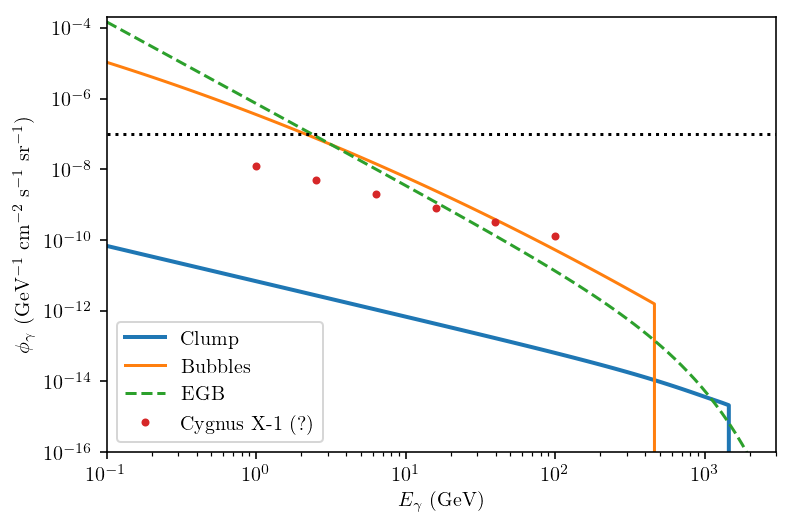

In [36]:
e_gs = np.logspace(-1, np.log10(3e3), 100)

plt.loglog(e_gs, dphi_de_g(e_gs, 1e-2, 1e-2, 1e3, gamma_nfw, "nfw", 1*np.pi/180),
           label="Clump", linewidth=2)
plt.loglog(e_gs, dphi_de_g_bubbles(e_gs), label="Bubbles")
plt.loglog(e_gs, dphi_de_egb_fermi(e_gs), '--', label="EGB")
plt.loglog(e_gs_cyg, dphi_de_g_cyg, '.', label="Cygnus X-1 (?)")
plt.axhline(1e-7, color='k', linestyle=':')

plt.autoscale(tight=True)
plt.ylim(1e-16, 2e-4)
plt.xlabel(r"$E_\gamma$ (GeV)")
plt.ylabel(r"$\phi_\gamma$ (GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$)")
plt.legend()

## Save results

In [ ]:
for var in ["dist", "r_s"]:
    np.savetxt(base_path_nfw + var + ".csv", eval(var), delimiter=',')

for var in ["rho_s", "rho_rel", "lum", "dphi_de_g", "extent", "lw",
            "rho_s_fermi_ps", "dphi_de_g_ext_rel"]:
    np.savetxt(base_path_nfw + var + ".csv", eval(var + "_nfw"), delimiter=',')

## Plot everything together

In [ ]:
levels_nfw = {"lum": [4e48, 1e49, 3e49, 1e50, 3e50, 1e51, 3e51, 3e52, 4e54],
              "rho_s": [1e-2, 0.1, 1, 10, 1e2, 1e3, 1e4],
              "dphi_de_g": [5e-17, 1e-16, 3e-16, 1e-15, 3e-15, 1e-14, 3e-14, 1e-13, 1e-12, 1e-10, 1e-8],
              "rho_rel": [2, 3, 10, 30, 100, 300, 1e3, 3e3, 3e4],
              "extent": [2, 5, 10, 20, 50, 100, 200, 300, 400, 450, 500, 550]}

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True,
                        figsize=(8, 10))

if gamma_nfw == 1:
    fig.suptitle(r"$\gamma_{\mathrm{NFW}} = " + "{:.0f}".format(gamma_nfw) + r"$")
elif gamma_nfw == 0.5:
    fig.suptitle(r"$\gamma_{\mathrm{NFW}} = " + "{:.1f}".format(gamma_nfw) + r"$")

for ax in axs.flatten():
    ax.set_xlabel(r"$d$ (kpc)")
    ax.set_ylabel(r"$r_s$ (kpc)")
    # Line width constraint
    ax.contourf(dist, r_s, lw_nfw, levels=[n_sigma, np.max(lw_nfw)],
                colors='k', alpha=0.2)
    # Point source constraint
    ax.contourf(dist, r_s, rho_s_fermi_ps_nfw - rho_s_nfw, levels=[-1e100, 0],
                colors=[colors[1]], alpha=0.2)
    # Extended source vs EGB
    ax.contourf(dist, r_s, dphi_de_g_ext_rel_nfw, levels=[1e1, 1e100],
                colors=[colors[8]], alpha=0.2)

ax = axs[0, 0]
# Must be done before plotting to get label formatting right.
# Only need to do this for one subplot.
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(dist[[0, -1]])
ax.set_ylim(r_s[[0, -1]])
ax.set_title(r"$L$ (GeV$^2$/cm$^3$)", pad=10)
sci_contours(dist, r_s, lum_nfw*Hz_to_GeV2_cm3, ax, levels=levels_nfw["lum"])

ax = axs[0, 1]
ax.set_title(r"$\rho_s$ (GeV/cm$^3$)", pad=10)
sci_contours(dist, r_s, rho_s_nfw, ax, levels=levels_nfw["rho_s"])

ax = axs[1, 0]
ax.set_title(r"$\phi_\gamma(230\ \mathrm{GeV})$"
             r" (GeV cm$^2$ s sr)$^{-1}$", pad=10)
sci_contours(dist, r_s, dphi_de_g_nfw, ax, levels=levels_nfw["dphi_de_g"])

ax = axs[1, 1]
ax.set_title(r"$\frac{\rho_{\mathrm{NFW}}(d) +"
             r"\rho_\oplus}{\rho_\oplus}$", pad=10)
normal_contours(dist, r_s, rho_rel_nfw, ax, levels=levels_nfw["rho_rel"])

ax = axs[2, 0]
ax.set_title(r"$\frac{\theta_{68\%}(230\ \mathrm{GeV})}{\theta_{\rm PSF}}$", pad=10)
normal_contours(dist, r_s, extent_nfw/fermi_psf, ax, levels=levels_nfw["extent"])

ax = axs[2, 1]
ax.set_title(r"$p_{N {\rm -body}}$", pad=10)
# if gamma_nfw == 0.5:
#     sci_contours(dist_pr, r_s_pr, pr_nfw, ax, levels=np.logspace(-15, -12, 4))
# elif gamma_nfw == 1:
#     sci_contours(dist_pr, r_s_pr, pr_nfw, ax, levels=np.logspace(-13, -7, 7))


fig.tight_layout(rect=[0, 0.03, 1, 0.975])
fig.savefig("figures/contour_plots_nfw_gamma_{:.1f}.pdf".format(gamma_nfw))

In [ ]:
os.system("say 'Done with gamma NFW equals 0.5'")

# Exponential/tidally truncated profile

In [9]:
dist = np.logspace(-3, 0, 9)
r_s = np.logspace(-3, 1, 9)
gamma_exp = np.array([0.28594, 0.450207, 0.577731, 0.689375, 0.794874,
                      0.901285, 1.01681, 1.15728, 1.38515])
dist_mg, r_s_mg, gamma_exp_mg = np.meshgrid(dist, r_s, gamma_exp)

base_path_exp = 'data/exp_gamma_grid/'

## Load results

In [3]:
# for var in ["dist", "r_s"]:
#     exec(var + " = np.loadtxt('" + base_path_exp + var + ".csv', delimiter=',')")
# dist_mg, r_s_mg = np.meshgrid(dist, r_s)

# for var in ["rho_s", "rho_rel", "lum", "dphi_de_g", "extent", "lw",
#             "rho_s_fermi_ps", "dphi_de_g_ext_rel"]:
#     exec(var + "_exp = np.loadtxt('" + base_path_exp + var + ".csv', delimiter=',')")

## Recompute

### $\rho_s$

In [10]:
rho_s_exp = rho_s_dampe(dist_mg, r_s_mg, gamma_exp_mg, "exp")

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)
finite_clump_vectorized.py:286: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(residual_iflux / (dm_iflux_near + dm_iflux_far))
/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it 

### $\mathcal{L}$

In [14]:
lum_exp = luminosity(r_s_mg, rho_s_exp, gamma_exp_mg, "exp")

## Save results

In [33]:
for var in ["dist", "r_s", "gamma_exp"]:
    np.savetxt(base_path_exp + var + ".csv", eval(var), delimiter=',')

for i, g in enumerate(gamma_exp):
    rho_path = "{:s}rho_s_{}.csv".format(base_path_exp, g)
    np.savetxt(rho_path, rho_s_exp[:, :, i])
    lum_path = "{:s}lum_{}.csv".format(base_path_exp, g)
    np.savetxt(lum_path, lum_exp[:, :, i])